Linear Regression
====================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

This tour studies linear regression method in conjunction with
regularization.
It contrasts ridge regression and the Lasso.

We recommend that after doing this Numerical Tours, you apply it to your
own data, for instance using a dataset from <https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/ LibSVM>.

_Disclaimer:_ these machine learning tours are intended to be
overly-simplistic implementations and applications of baseline machine learning methods.
For more advanced uses and implementations, we recommend
to use a state-of-the-art library, the most well known being
<http://scikit-learn.org/ Scikit-Learn>

In [1]:
from nt_toolbox.general import *
from nt_toolbox.signal import *
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


/Users/gpeyre/anaconda/envs/p34/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Usefull function to convert to a column vector.

In [2]:
def MakeCol(y): return reshape(y, (y.size,1) )

Dataset Loading
---------------
We test the method on the prostate dataset in $n=97$ samples with
features $x_i \in \RR^p$ in dimension $p=8$. The goal is to predict the price value
$y_i \in \RR$.

Load the dataset.

In [3]:
from scipy import io
name = 'prostate';
U = io.loadmat('nt_toolbox/data/ml-' + name)
A = U['A']
class_names = U['class_names']
A = A[random.permutation(A.shape[0]),:]

Randomly permute it.

In [4]:
A = A[random.permutation(A.shape[0]),:]

Separate the features $X$ from the data $y$ to predict information.

In [5]:
X = A[:,0:-2];
y = MakeCol( A[:,-2] );
c = MakeCol( A[:,-1] );

$n$ is the number of samples, $p$ is the dimensionality of the features,

In [6]:
[n,p] = X.shape
print(n,p)

97 8


Split into training and testing.

In [7]:
I0 = find(c==1) # train
I1 = find(c==0) # test
n0 = I0.size
n1 = n-n0
X0 = X[I0,:]
y0 = y[I0]
X1 = X[I1,:]
y1 = y[I1]

Normalize the features by the mean and std of the *training* set.
This is optional.

In [8]:
mX0 = X0.mean(axis=0)
sX0 = X0.std(axis=0)
X0 = (X0-mX0)/sX0
X1 = (X1-mX0)/sX0

Remove the mean (computed from the *test* set) to avoid introducing a bias term and a constant regressor.
This is optional.

In [9]:
m0 = y0.mean()
y0 = y0-m0
y1 = y1-m0

Dimenionality Reduction and PCA
-------------------------------
In order to display in 2-D or 3-D the data, dimensionality is needed.
The simplest method is the principal component analysis, which perform an
orthogonal linear projection on the principal axsis (eigenvector) of the
covariance matrix.


Display the covariance matrix of the training set.

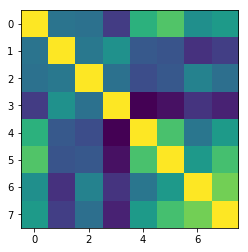

In [10]:
C = X0.transpose().dot(X0)
imshow(C);

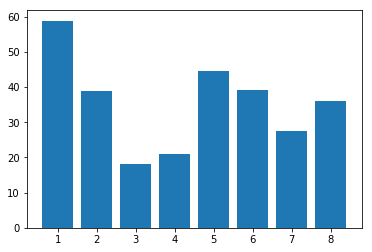

In [12]:
clf
bar(arange(1,p+1),X0.transpose().dot(y0))
axis('tight');

Compute PCA ortho-basis and
the feature in the PCA basis.

In [13]:
U, s, V = np.linalg.svd(X0)
X0r = X0.dot( transpose(V))

Plot sqrt of the eigenvalues.

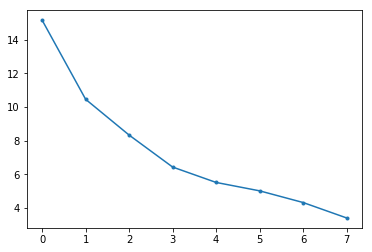

In [14]:
plot(s, '.-');

Display the features.

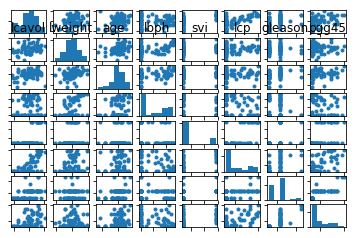

In [16]:
pmax = min(p,8)
k = 0
clf
for i in arange(0,pmax):
    for j in arange(0,pmax):
        k = k+1
        subplot(pmax,pmax,k)
        if i==j:
            hist(X0[:,i],6)
            axis('tight')
        else:
            plot(X0[:,j],X0[:,i], '.')
        axis('tight')
        if i==1:
            title(class_names[0][j][0])
        tick_params(axis='x', labelbottom='off')
        tick_params(axis='y', labelleft='off')

Display the points cloud of feature vectors in 2-D PCA space.

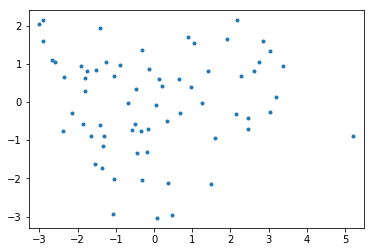

In [17]:
plot(X0r[:,0], X0r[:,1], '.')
axis('equal');

1D plot of the function to regress along the main eigenvector axes.

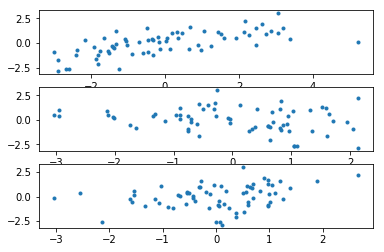

In [18]:
clf;
for i in arange(0,3):
    subplot(3,1,i+1)
    plot(X0r[:,i], y0, '.')
    axis('tight')

Linear Regression
-----------------
We look for a linear relationship
  $ y_i = \dotp{w}{x_i} $
written in matrix format
  $ y= X w $
where the rows of $X \in \RR^{n \times p}$ stores the features $x_i \in \RR^p$.


Since here $ n > p $, this is an over-determined system, which can
solved in the least square sense
  $$ \umin{ w }  \norm{Xw-y}^2 $$
whose solution is given using the Moore-Penrose pseudo-inverse
  $$ w = (X^\top X)^{-1} X^\top y $$


Least square solution.

In [19]:
w = inv(X0.transpose().dot(X0)).dot( X0.transpose().dot(y0) )

Prediction (along 1st eigenvector).

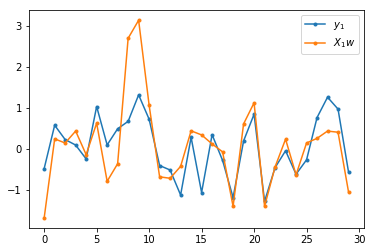

In [20]:
clf;
plot( X1.dot(w), '.-' )
plot( y1, '.-' )
axis('tight')
legend(('$y_1$', '$X_1 w$'));

Mean-square error on testing set.

In [21]:
E = norm(X1.dot(w)-y1) / norm(y1)
print(( 'Relative prediction error: ' + str(E) ) );

Relative prediction error: 0.70234476931


Regularization is obtained by introducing a penalty. It is often called
ridge regression, and is defined as
  $$ \umin{ w }  \norm{Xw-y}^2 + \lambda \norm{w}^2 $$
where $\lambda>0$ is the regularization parameter.


The solution is given using the following equivalent formula
  $$ w = (X^\top X + \lambda \text{Id}_p )^{-1} X^\top y, $$
  $$ w = X^\top ( XX^\top + \lambda \text{Id}_n)^{-1} y, $$
When $p<n$ (which is the case here), the first formula should be
prefered.


In contrast, when the dimensionality $p$ of the feature is very
large and there is little data, the second is faster. Furthermore, this
second expression is generalizable to Kernel Hilbert space setting,
corresponding possibly to $p=+\infty$ for some kernels.

In [22]:
Lambda = .2*norm(X0)**2;
w = inv(X0.transpose().dot(X0) + Lambda*eye(p)).dot( X0.transpose().dot(y0) )
u = inv(X0.dot(X0.transpose()) + Lambda*eye(n0)). dot( y0 )
w1 = X0.transpose().dot( u )
print( ('Error (should be 0): ' + str( norm(w-w1)/norm(w) ) ) )

Error (should be 0): 6.54622034225e-16


__Exercise 1__

Display the evolution of the test error $E$ as a function of $\lambda$.
ind optimal lambda
isplay error evolution.

Ridge: 67.9067212566%


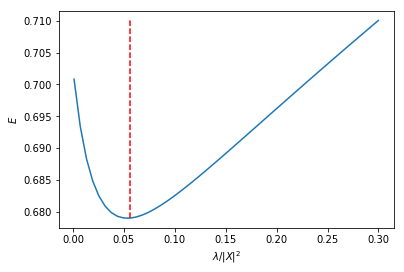

In [25]:
run -i nt_solutions/ml_2_regression/exo1

In [26]:
## Insert your code here.

__Exercise 2__

Display the regularization path, i.e. the evolution of $w$ as a function
of $\lambda$.

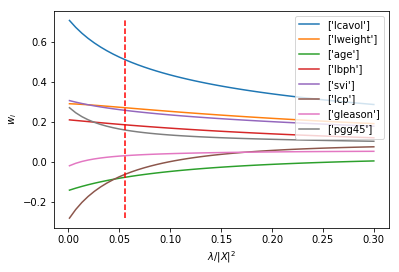

In [28]:
run -i nt_solutions/ml_2_regression/exo2

In [29]:
## Insert your code here.

Sparse Regularization
---------------------
In order to perform feature selection (i.e. select a subsect of the
features which are the most predictive), one needs to replace the
$\ell^2$ regularization penalty by a sparsity inducing regularizer. The
most well known is the $\ell^1$ norm
$$ \norm{w}_1 \eqdef \sum_i \abs{w_i} . $$


The energy to minimize is
$$ \umin{w} J(w) \eqdef \frac{1}{2}\norm{X w-y}^2 + \lambda \norm{w}_1. $$

In [30]:
def J(w,Lambda): return 1/2*norm(X0.dot(w)-y0)**2 + Lambda*norm(w,1)

The simplest iterative algorithm to perform the minimization is the
so-called iterative soft thresholding (ISTA), aka proximal gradient aka
forward-backward.


It performs first a gradient step (forward) of the smooth part $\frac{1}{2}\norm{X w-y}^2$ of the
functional and then a proximal step (backward) step which account for the
$\ell^1$ penalty and induce sparsity. This proximal step is the soft-thresholding operator
$$ \Ss_s(x) \eqdef \max( \abs{x}-\lambda,0 ) \text{sign}(x).  $$

In [31]:
def Soft(x,s): return maximum( abs(x)-s, zeros(x.shape)  ) * sign(x)

The ISTA algorithm reads
$$ w_{k+1} \eqdef \Ss_{\la\tau}( w_k - \tau X^\top ( X w_k - y )  ), $$
where, to ensure convergence, the step size should verify $ 0 < \tau <
2/\norm{X}^2  $ where $\norm{X}$ is the operator norm.


Display the soft thresholding operator.

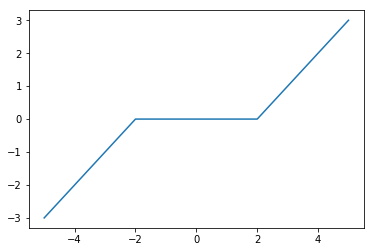

In [32]:
t = linspace(-5,5,201)
clf
plot(t,Soft(t,2)) 
axis('tight');

Descent step size.

In [33]:
tau = 1.5/norm(X0,2)**2

Choose a regularization parameter $\la$.

In [34]:
lmax = abs( transpose(X0).dot(y0) ).max()
Lambda = lmax /10

Initialization $w_0$.

In [35]:
w = zeros((p,1))

A single ISTA step.

In [36]:
C = X0.transpose().dot(X0)
u = X0.transpose().dot(y0)
def ISTA(w,Lambda,tau): return Soft( w-tau*( C.dot(w)-u ), Lambda*tau )
w = ISTA(w,Lambda,tau)

__Exercise 3__

Implement the ISTA algorithm, display the convergence of the energy.

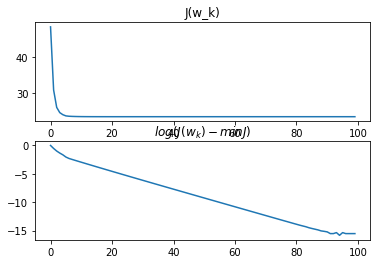

In [37]:
run -i nt_solutions/ml_2_regression/exo3

In [38]:
## Insert your code here.

__Exercise 4__

Compute the test error along the full regularization path. You can start by large $\lambda$ and use a warm restart procedure
to reduce the computation time. Compute the classification error.
ind optimal lambda
isplay error evolution.

Lasso: 65.4218437873%


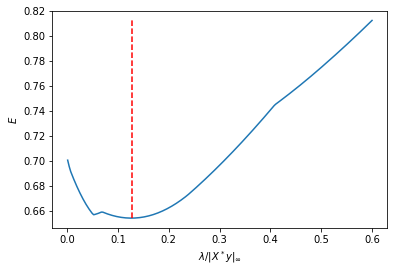

In [39]:
run -i nt_solutions/ml_2_regression/exo4

In [40]:
## Insert your code here.

__Exercise 5__

Display the regularization path, i.e. the evolution of $w$ as a function
of $\lambda$.
lot(lambda_list, W', 'LineWidth', 2);

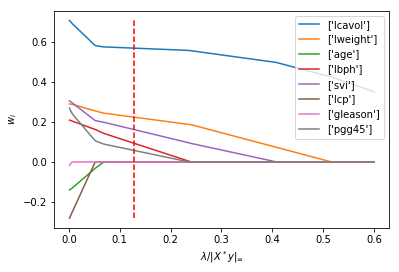

In [41]:
run -i nt_solutions/ml_2_regression/exo5

In [38]:
## Insert your code here.

__Exercise 6__

Compare the optimal weights for ridge and lasso.

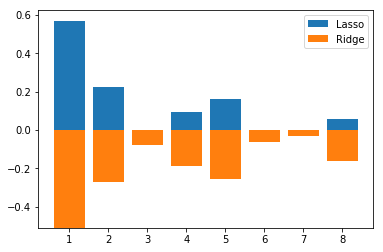

In [44]:
run -i nt_solutions/ml_2_regression/exo8

<script>
  $(document).ready(function(){
      $('div.prompt').hide();
  });
</script>

In [ ]:
<script>
  $(document).ready(function(){
      $('div.prompt').hide();
  });
</script>